# LangSmith Evaluation Deep Dive

## Preface

* `Video 1:` Slides reviewing why evals are important [here](https://docs.google.com/presentation/d/1y_dYspY8odgVvE4OfimCLmw9QHz7QPkYNMvK8wyg9bY/edit?usp=sharing)
* `Video 2:` Slides reviewing LangSmith primitives [here](https://docs.google.com/presentation/d/1N1JKe_7qLIuiY2M40gKFGGYTb37t6F_oqGLUpw5oXy4/edit?usp=sharing)

## Preface

Overview of the LangSmith eval landscape.

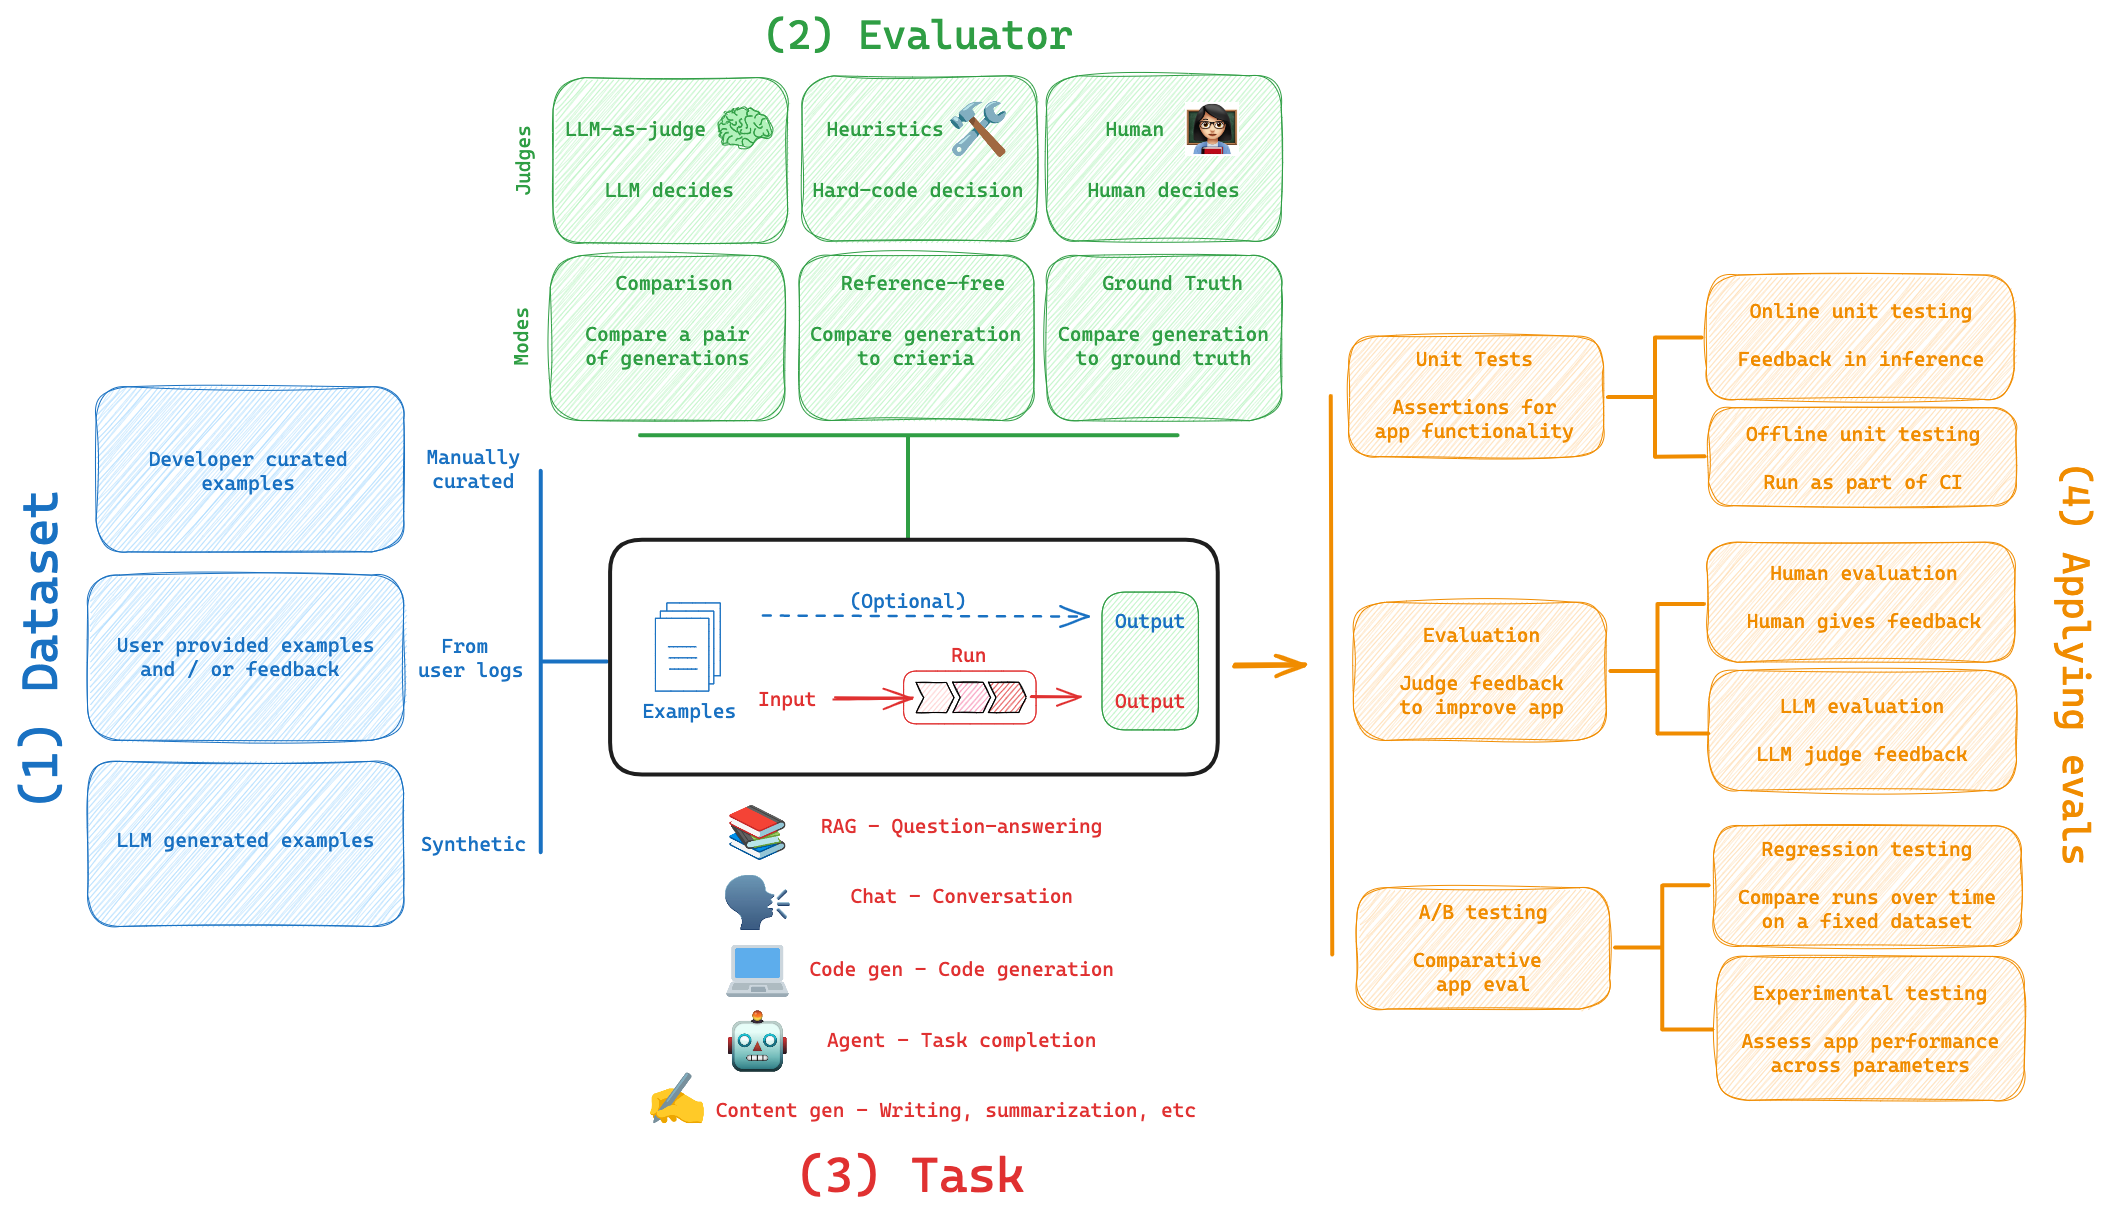

## Enviornment

In [ ]:
! pip install langsmith openai ollama

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # enables tracing 
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

In [ ]:
import os
os.environ['LANGCHAIN_PROJECT'] = 'Test'

# 3. Dataset: Manually Curated

`Question:` 

How can I build my own dataset?

`Setup:` 

Let's build a dataset of question-answer pairs on this blog post about `DBRX`:

https://www.databricks.com/blog/introducing-dbrx-new-state-art-open-llm

We'll build a `Manually Curated` dataset of input, output pairs:

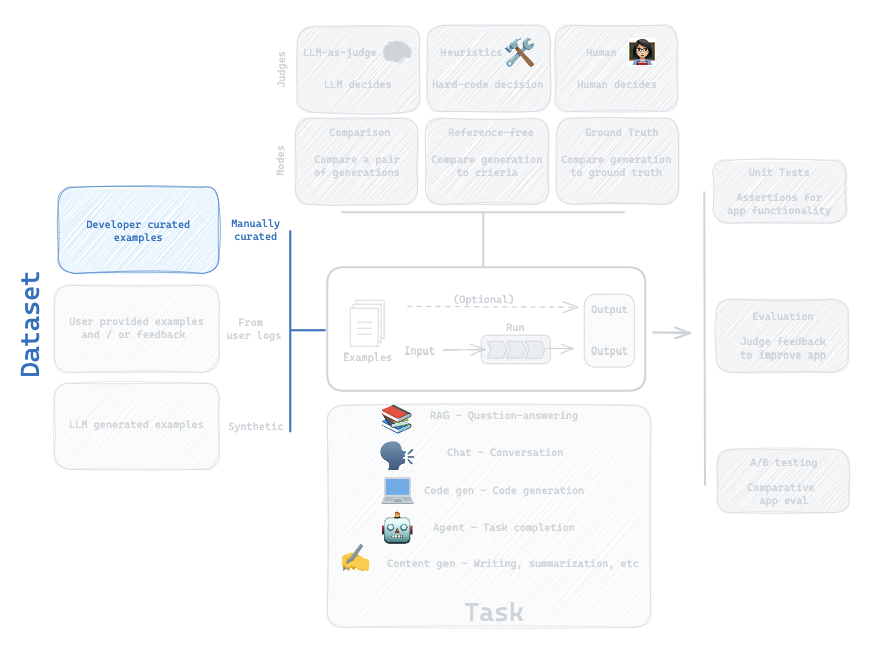

In [ ]:
import pandas as pd

# QA
inputs = [
    "How many tokens was DBRX pre-trained on?",
    "Is DBRX a MOE model and how many parameters does it have?",
    "How many GPUs was DBRX trained on and what was the connectivity between GPUs?"
]

outputs = [
    "DBRX was pre-trained on 12 trillion tokens of text and code data.",
    "Yes, DBRX is a fine-grained mixture-of-experts (MoE) architecture with 132B total parameters.",
    "DBRX was trained on 3072 NVIDIA H100s connected by 3.2Tbps Infiniband"
]

# Dataset
qa_pairs = [{"question": q, "answer": a} for q, a in zip(inputs, outputs)]
df = pd.DataFrame(qa_pairs)

# Write to csv
csv_path = "/Users/rlm/Desktop/DBRX_eval.csv"
df.to_csv(csv_path, index=False)

LangSmith SDK docs:

* https://docs.smith.langchain.com/evaluation/quickstart#1-create-a-dataset

In [ ]:
from langsmith import Client

client = Client()
dataset_name = "DBRX"

# Store
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="QA pairs about DBRX model.",
)
client.create_examples(
    inputs=[{"question": q} for q in inputs],
    outputs=[{"answer": a} for a in outputs],
    dataset_id=dataset.id,
)

Update dataset

In [ ]:
new_questions = [
    "What is the context window of DBRX Instruct?", 
]

new_answers = [
    "DBRX Instruct was trained with up to a 32K token context window.",
]

# See updated version in the UI
client.create_examples(
    inputs=[{"question": q} for q in new_questions],
    outputs=[{"answer": a} for a in new_answers],
    dataset_id=dataset.id,
)

We can also create a dataset directly from a csv with the LangSmith UI.

LangSmith UI docs:

https://docs.smith.langchain.com/evaluation/faq/datasets-webapp

# 4. Dataset: From User Logs

`Question:` 

How can I save user logs as a dataset for future testing?

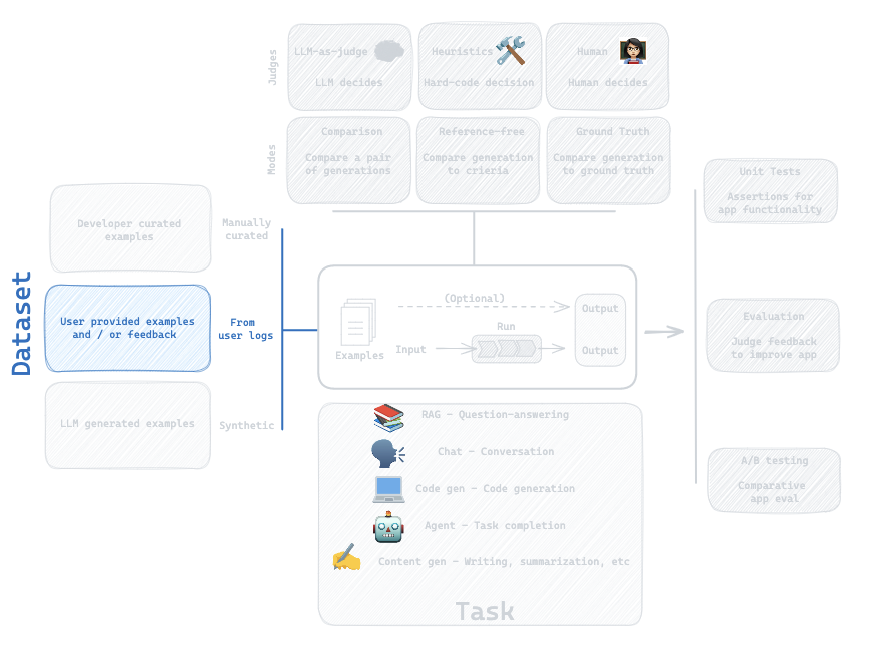

In [ ]:
# Create a new project where user question are logged

import os
os.environ['LANGCHAIN_PROJECT'] = 'DBRX'

In [ ]:
# Load blog post

import requests
from bs4 import BeautifulSoup
url = 'https://www.databricks.com/blog/introducing-dbrx-new-state-art-open-llm'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
text = [p.text for p in soup.find_all('p')]
full_text = '\n'.join(text)

In [ ]:
# OpenAI API

import openai
from langsmith.wrappers import wrap_openai
openai_client = wrap_openai(openai.Client())

def answer_dbrx_question_oai(inputs: dict) -> dict:
    """
    Generates answers to user questions based on a provided website text using OpenAI API.

    Parameters:
    inputs (dict): A dictionary with a single key 'question', representing the user's question as a string.

    Returns:
    dict: A dictionary with a single key 'output', containing the generated answer as a string.
    """

    # System prompt 
    system_msg = f"Answer user questions in 2-3 sentences about this context: \n\n\n {full_text}"
    
    # Pass in website text
    messages = [{"role": "system", "content": system_msg},
                {"role": "user", "content": inputs["question"]}]

    # Call OpenAI
    response = openai_client.chat.completions.create(messages=messages, model="gpt-3.5-turbo")

    # Response in output dict
    return {"answer": response.dict()['choices'][0]['message']['content']} 

In [ ]:
# User question example

answer_dbrx_question_oai({"question":"What are the main differences in training efficiency between MPT-7B vs DBRX?"})

In [ ]:
# User question example

answer_dbrx_question_oai({"question":"How many tokens was DBRX pre-trained on?"})

# 5. LLM-as-Judge: Built-in evaluator

`Question:` 

How can I evaluate the my LLM against my dataset?

`Evaluation flow`

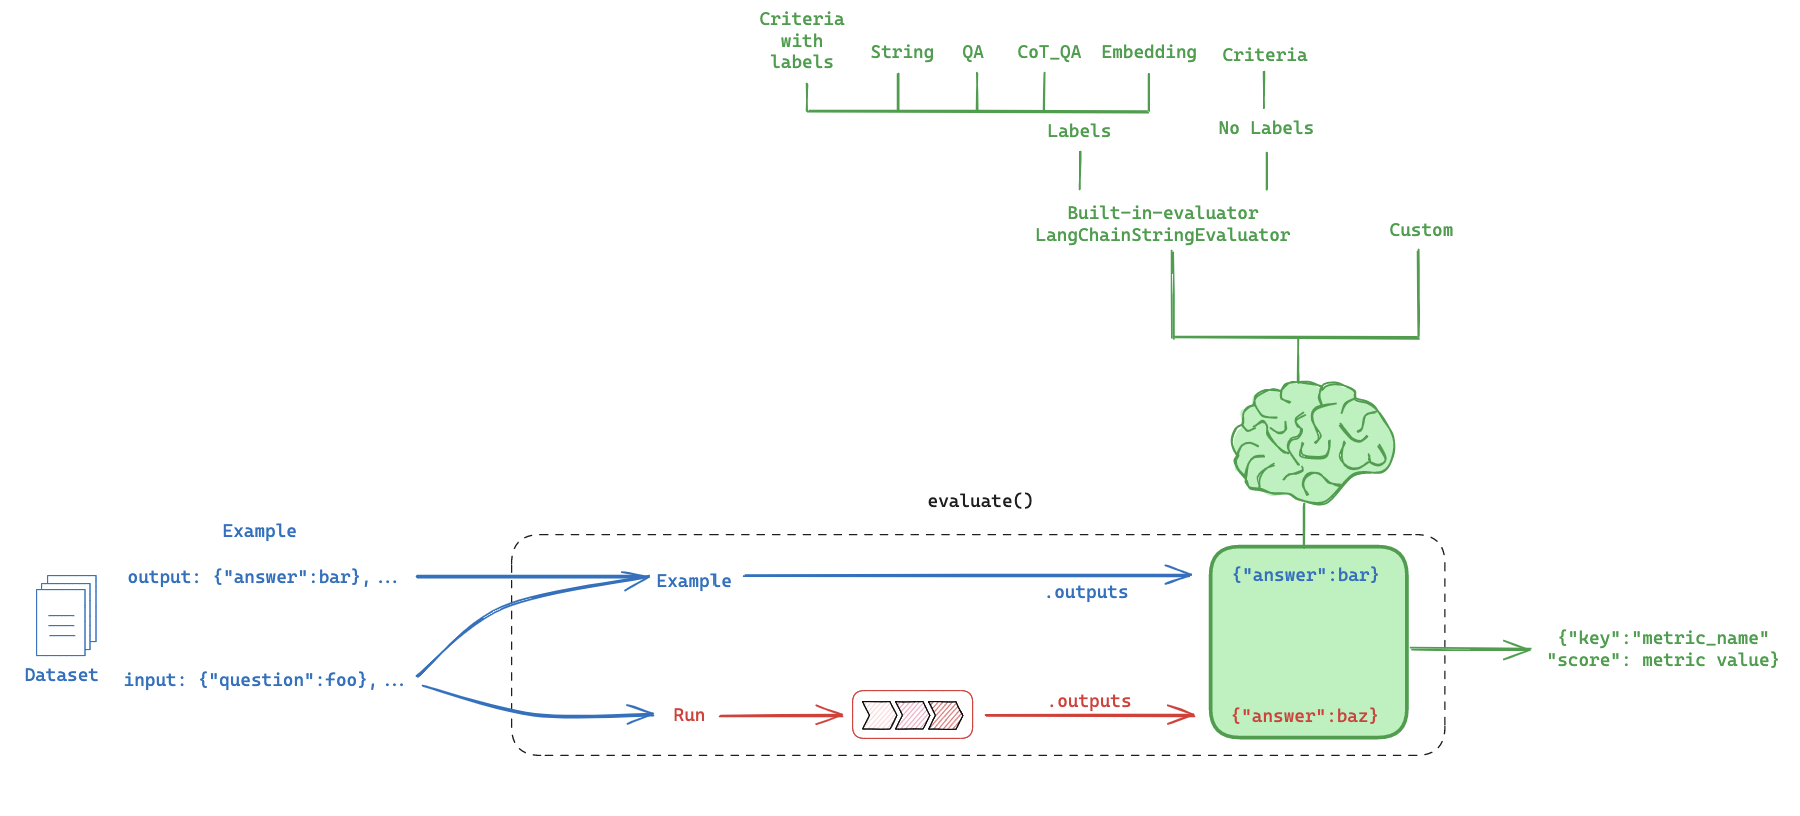

`Built-in evaluator`

https://docs.smith.langchain.com/evaluation/faq/evaluator-implementations

`CoT_qa`

```
Use chain of thought "reasoning" before determining a final verdict
```

In [ ]:
from langsmith.evaluation import evaluate, LangChainStringEvaluator

# Evaluators
qa_evalulator = [LangChainStringEvaluator("cot_qa")]
dataset_name = "DBRX"

experiment_results = evaluate(
    answer_dbrx_question_oai,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-oai",
    # Any experiment metadata can be specified here
    metadata={
      "variant": "stuff website context into gpt-3.5-turbo",
    },
)

`What did we do?`

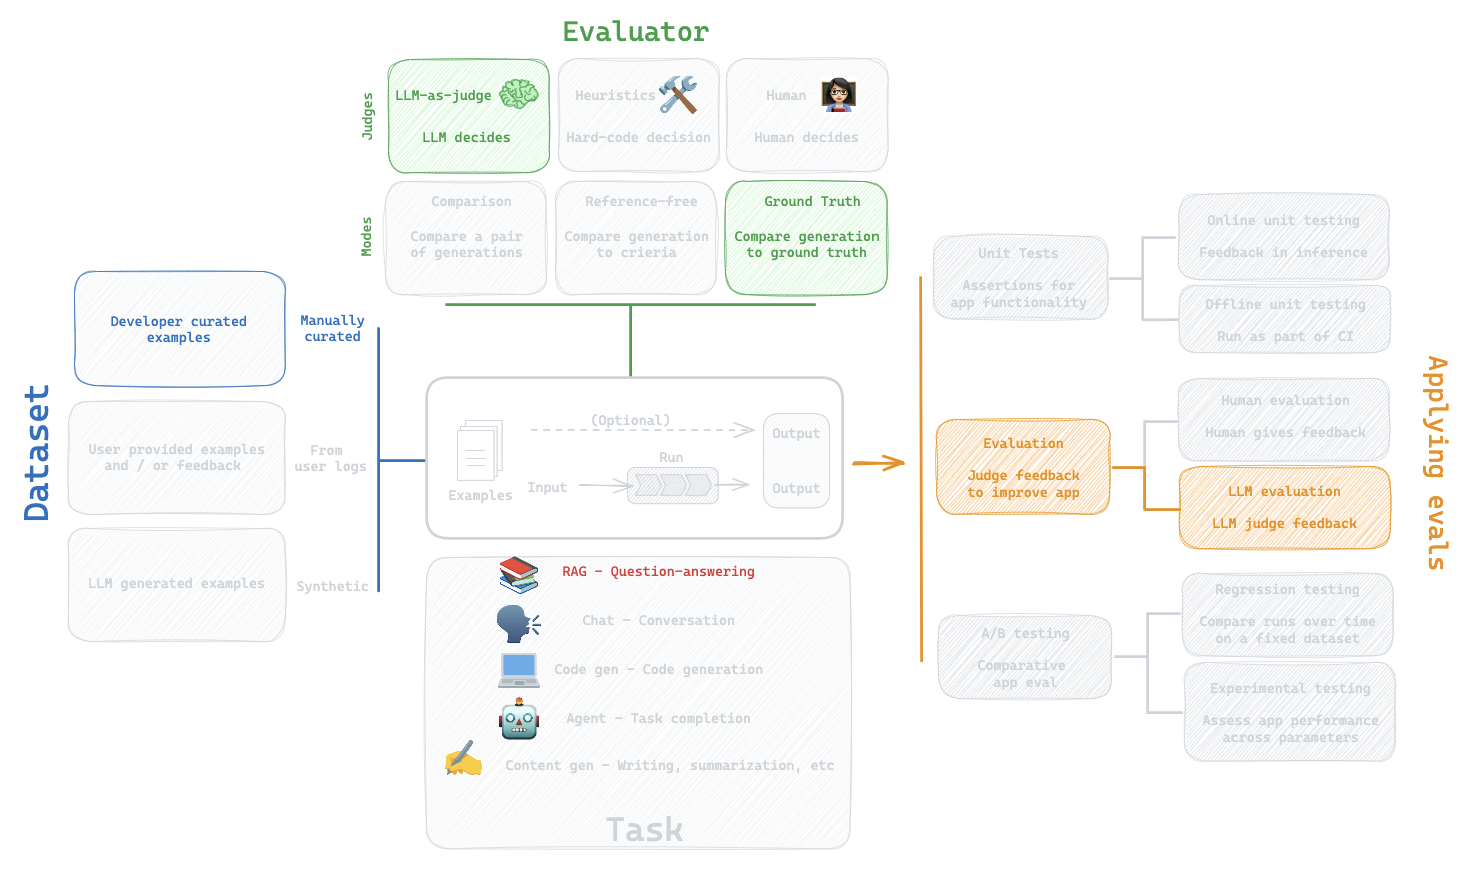

# 6. Custom evaluator

`Question:` 

How can I define my own custom evaluator? 

Let's say we want to define a simple assertion that an answer is actually generated.

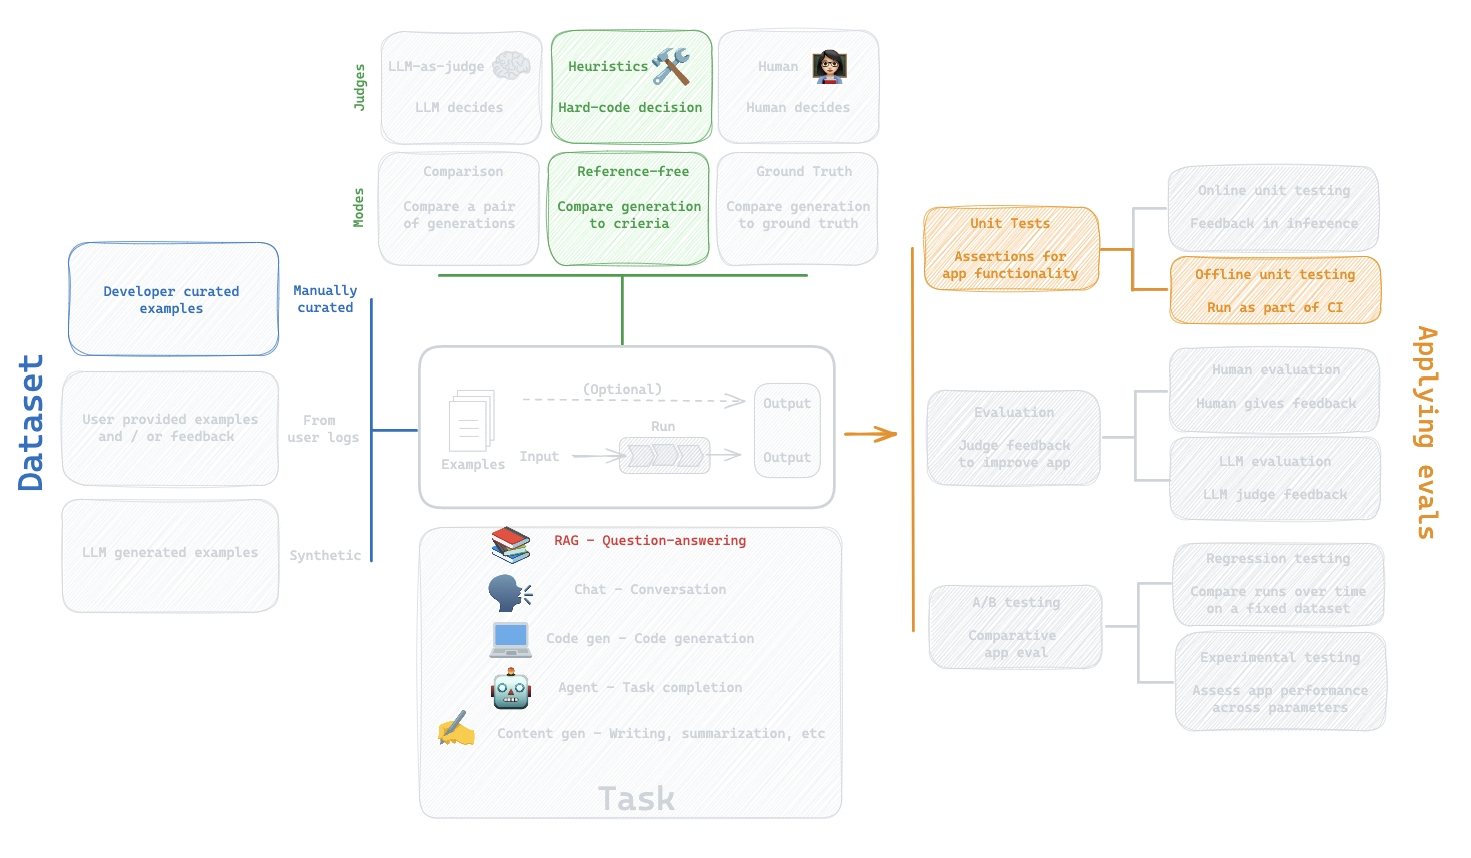

In [ ]:
from langsmith.schemas import Run, Example

def is_answered(run: Run, example: Example) -> dict: 

    # Get outputs
    student_answer = run.outputs.get("answer")
    
    # Check if the student_answer is an empty string
    if not student_answer:
        return {"key": "is_answered" , "score": 0} 
    else:
        return {"key": "is_answered" , "score": 1} 

# Evaluators
qa_evalulator = [is_answered]
dataset_name = "DBRX"

# Run
experiment_results = evaluate(
    answer_dbrx_question_oai,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-custom-eval-is-answered",
    # Any experiment metadata can be specified here
    metadata={
      "variant": "stuff website context into gpt-3.5-turbo",
    },
)

# 7. Comparison 

`Question:` 

How does `Mistral-7b` running locally compare to `GPT-3.5-turbo` for question-answering?
 
`Setup:`

https://github.com/ollama/ollama-python

```
ollama pull mistral
```

Instrument Ollama calls with LangSmith: 

https://docs.smith.langchain.com/cookbook/tracing-examples/traceable#using-the-decorator

In [ ]:
# Mistral

import ollama
from langsmith.run_helpers import traceable

@traceable(run_type="llm")
def call_ollama(messages, model: str):
    stream = ollama.chat(messages=messages, model='mistral', stream=True)
    response = ''
    for chunk in stream:
        print(chunk['message']['content'], end='', flush=True)
        response =  response + chunk['message']['content'] 
    return response

def answer_dbrx_question_mistral(inputs: dict) -> dict:
    """
    Generates answers to user questions based on a provided website text using Ollama serving Mistral locally.

    Parameters:
    inputs (dict): A dictionary with a single key 'question', representing the user's question as a string.

    Returns:
    dict: A dictionary with a single key 'output', containing the generated answer as a string.
    """

    # System prompt 
    system_msg = f"Answer user questions about this context: \n\n\n {full_text}"
    
    # Pass in website text
    messages = [{"role": "system", "content": system_msg},
                {"role": "user", "content": f'Answer the question in 2-3 sentences {inputs["question"]}' }]

    # Call Mistral
    response = call_ollama(messages, model="mistral")

    # Response in output dict
    return {"answer": response} 

result = answer_dbrx_question_mistral({"question":"What are the main differences in training efficiency between MPT-7B vs DBRX?"})

What are we doing?

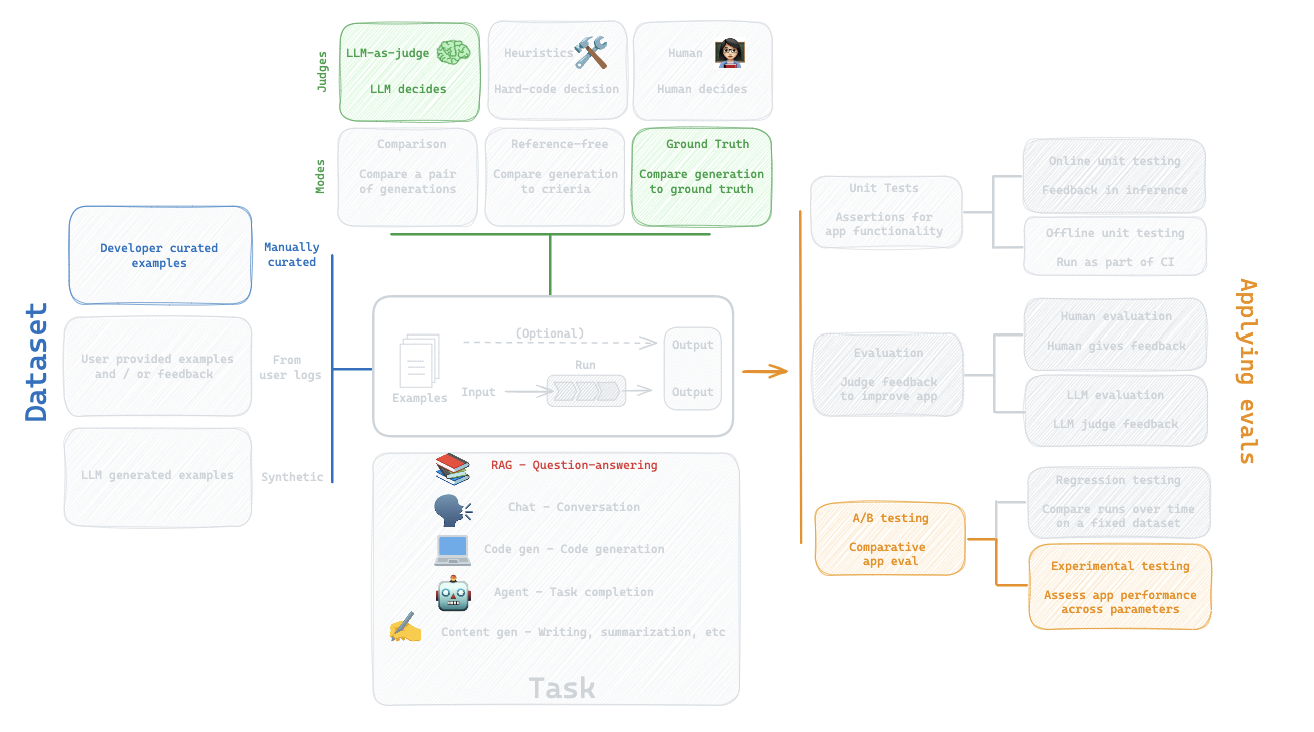

In [ ]:
# Evaluators
qa_evalulator = [LangChainStringEvaluator("cot_qa")]
dataset_name = "DBRX"

experiment_results = evaluate(
    answer_dbrx_question_mistral,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-mistral",
    # Any experiment metadata can be specified here
    metadata={
      "variant": "stuff website context into mistral",
    },
)

Use comparison view to inspect results.

# 8. Trace tagging and feedback

Nice blog post on some best practices:

https://hamel.dev/blog/posts/evals/

`Unit Tests`

* Online: Automatic retries during model inference
* Offline: CI, etc 

`Evaluation`

* Human-as-judge: Trace inspection, tagging
* LLM-as-judge: Human feedback to align grader

`A/B testing`

`Evaluating RAG`

`Fine-tuning`

* Best for learning syntax, style, and rules.
* RAG supplies the model with context or up-to-date facts.

--- 

Let's focus on `Human-as-judge: Trace inspection, tagging`

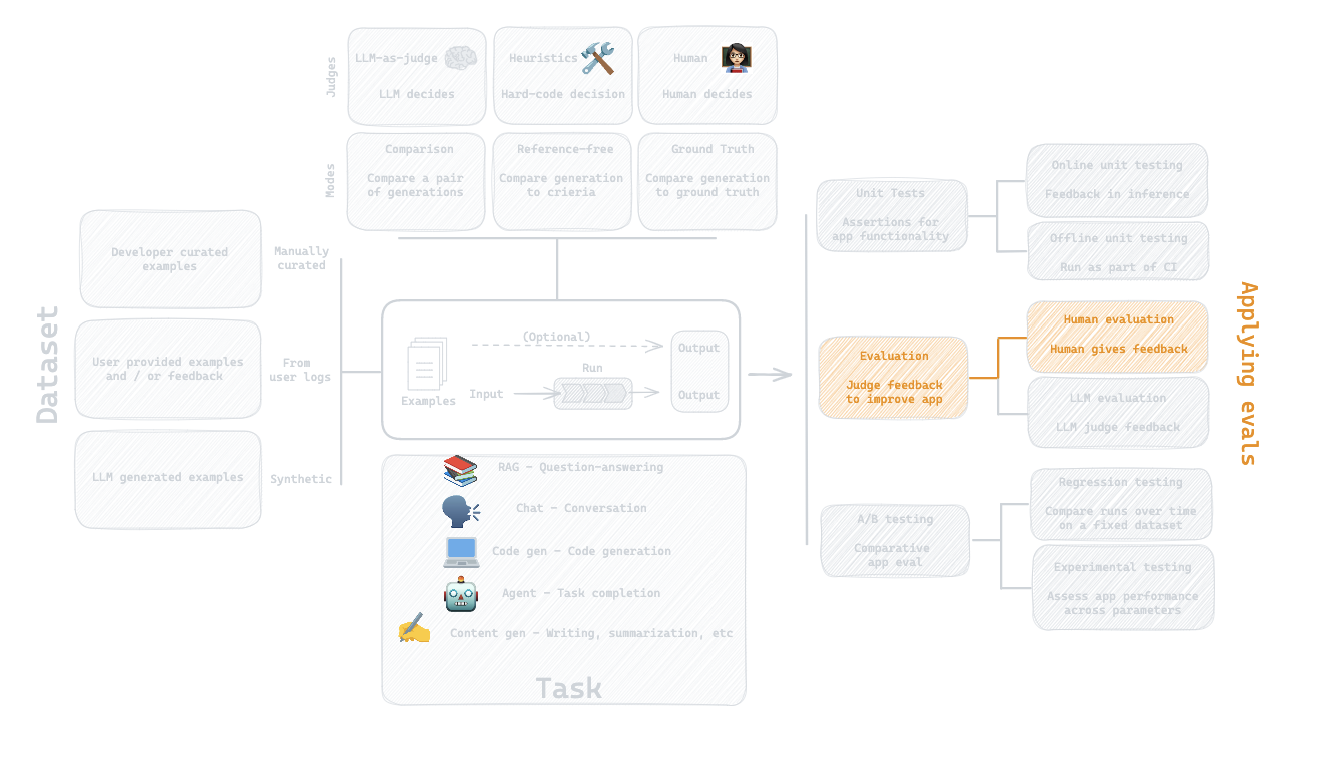

```
In Rechat’s case, this meant adding information like:

* What tool (feature) & scenario was being evaluated.
* Whether the trace resulted from a synthetic input or a real user input.
* Filters to navigate between different tools and scenario combinations.
* Links to the CRM and trace logging system for the current record.
```



You can instrument your app with tracing:

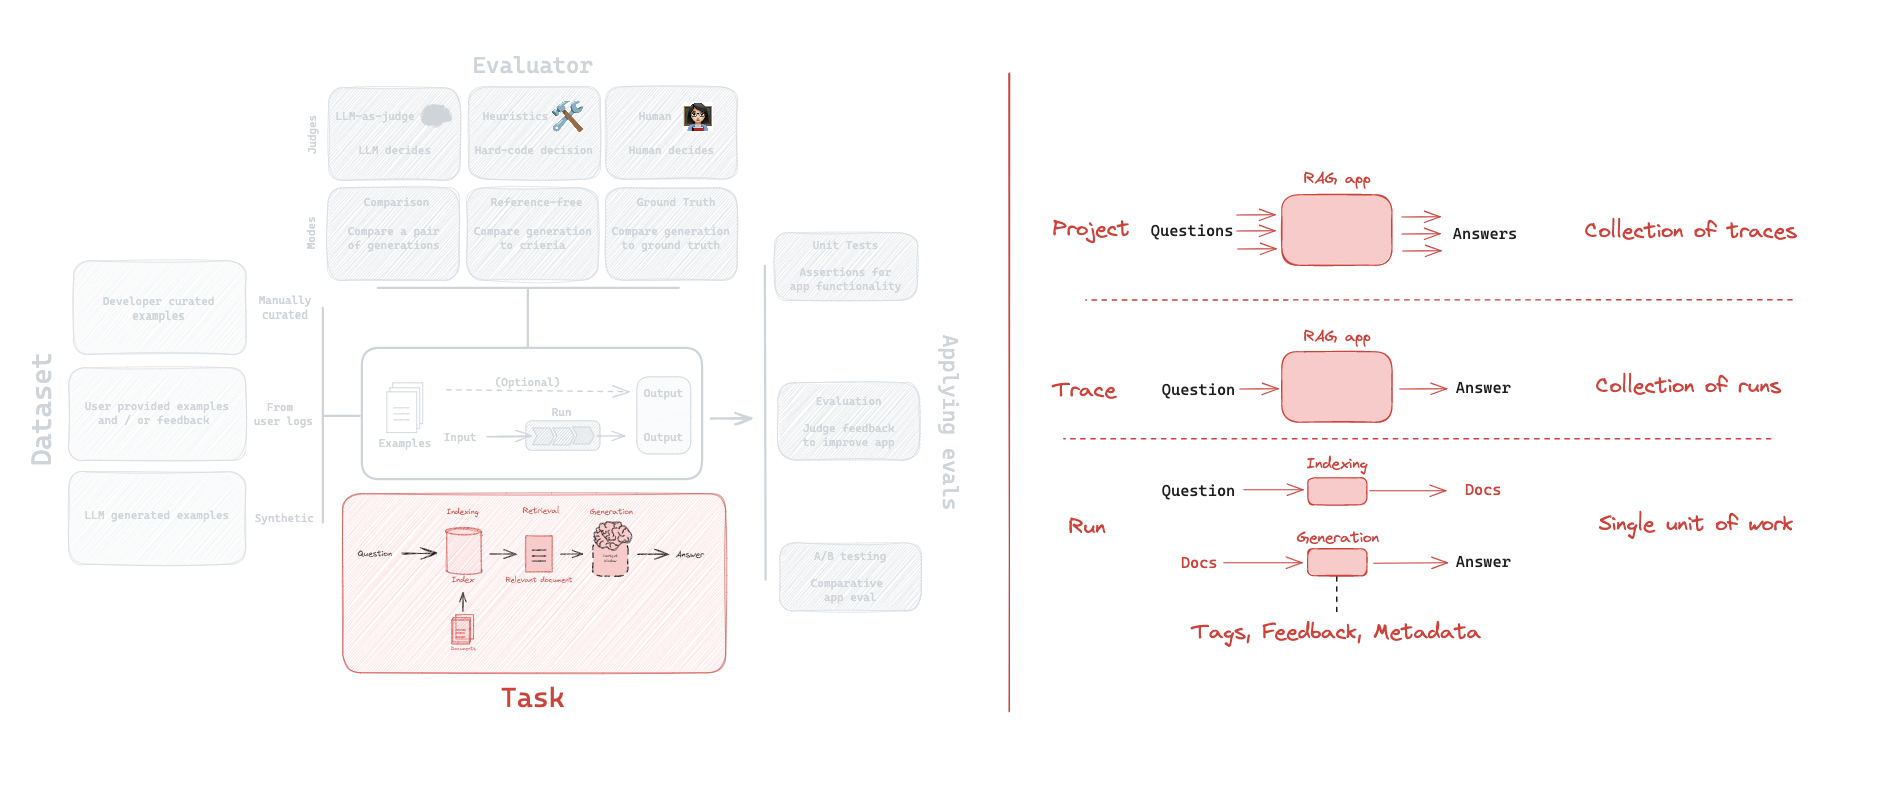

Docs: 
* https://docs.smith.langchain.com/tracing/quick_start
* https://docs.smith.langchain.com/cookbook/tracing-examples/traceable#configuring-traces

In [ ]:
os.environ['LANGCHAIN_PROJECT'] = 'DBRX_trace_tagging'

In [ ]:
import openai
from langsmith.run_helpers import traceable
from langsmith.wrappers import wrap_openai
openai_client = wrap_openai(openai.Client())

@traceable(run_type="chain",
           name="OAI QA",
           tags=["qa"],
           metadata={"document": "DBRX"})
def answer_dbrx_question_oai(inputs: dict) -> dict:
    """
    Generates answers to user questions based on a provided website text using OpenAI API.

    Parameters:
    inputs (dict): A dictionary with a single key 'question', representing the user's question as a string.

    Returns:
    dict: A dictionary with a single key 'output', containing the generated answer as a string.
    """

    # System prompt 
    system_msg = f"Answer user questions in 2-3 sentences about this context: \n\n\n {full_text}"
    
    # Pass in website text
    messages = [{"role": "system", "content": system_msg},
                {"role": "user", "content": inputs["question"]}]

    # Call OpenAI
    response = openai_client.chat.completions.create(messages=messages, model="gpt-3.5-turbo")

    # Response in output dict
    return {"answer": response.dict()['choices'][0]['message']['content']} 

question = "How does DBRX perform on programming and mathematics relative to other open models?"
answer_dbrx_question_oai({"question":question})

We can also log feedback.

In [ ]:
@traceable(run_type="chain",
           name="Mistral QA",
           tags=["qa"],
           metadata={"document": "DBRX"})
def answer_dbrx_question_mistral(inputs: dict) -> dict:
    """
    Generates answers to user questions based on a provided website text using Ollama serving Mistral locally.

    Parameters:
    inputs (dict): A dictionary with a single key 'question', representing the user's question as a string.

    Returns:
    dict: A dictionary with a single key 'output', containing the generated answer as a string.
    """

    # System prompt 
    system_msg = f"Answer user questions about this context: \n\n\n {full_text}"
    
    # Pass in website text
    messages = [{"role": "system", "content": system_msg},
                {"role": "user", "content": f'Answer the question in 2-3 sentences {inputs["question"]}' }]

    # Call Mistral
    response = call_ollama(messages, model="mistral")

    # Response in output dict
    return {"answer": response} 

In [ ]:
from uuid import uuid4
requested_uuid = uuid4()
question = "Why does mixture-of-experts improve compute efficiency?"
answer_dbrx_question_mistral({"question":question}, langsmith_extra={"tags": ["math question"],
                                                                              "metadata": {"topic": "math"},
                                                                              "run_id": requested_uuid})

In [ ]:
# Log feedback
client.create_feedback(
    requested_uuid, 
    "user_feedback", 
    score=1, 
    comment="Reasonable",
    source_info={"origin": "example notebook"}
)

# 9. Evaluating RAG

Nice blog post on some best practices:

https://hamel.dev/blog/posts/evals/

`Unit Tests`

* Online: Automatic retries during model inference
* Offline: CI, etc 

`Evaluation`

* Human-as-judge: Trace inspection, tagging
* LLM-as-judge: Human feedback to align grader

`A/B testing`

`Evaluating RAG`

`Fine-tuning`

* Best for learning syntax, style, and rules.
* RAG supply the model with context or up-to-date facts.

--- 

Let's focus on `Evaluating RAG`

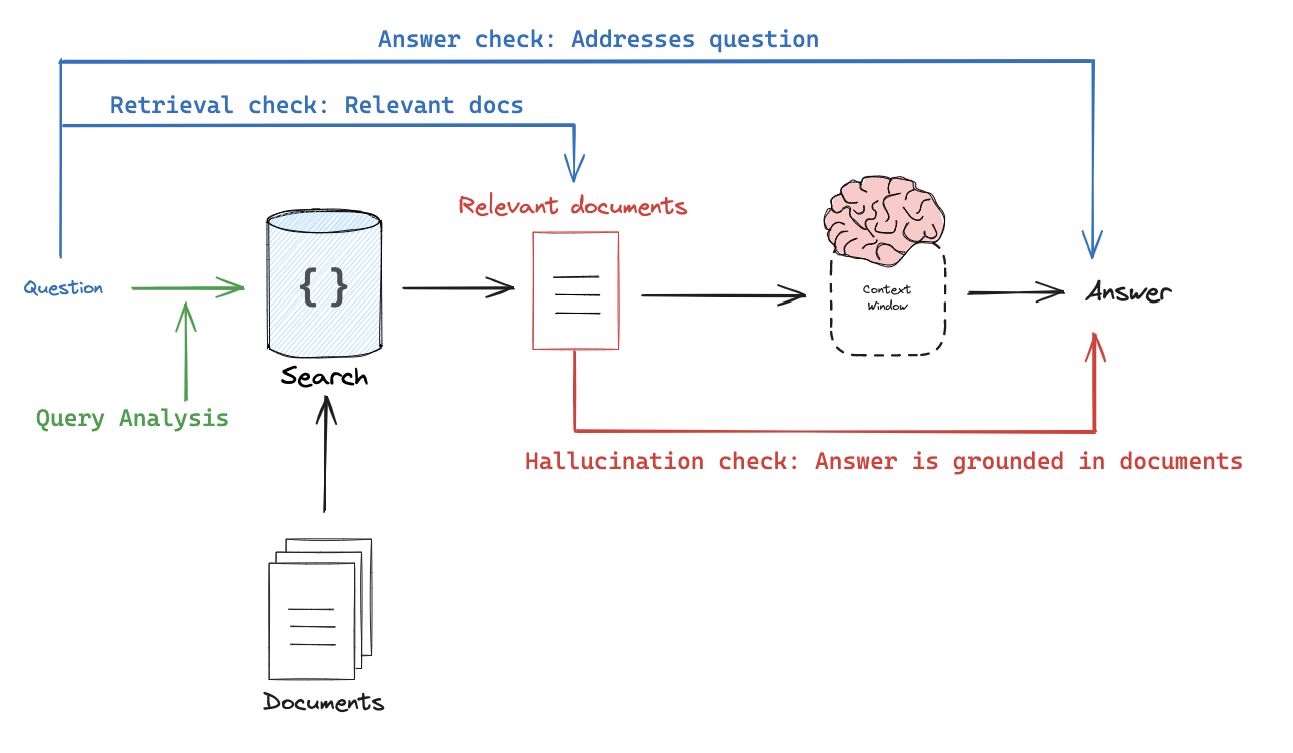

In [ ]:
! pip install langchain-community langchain

Useful docs - 

https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb

In [ ]:
### INDEXING ### 

from bs4 import BeautifulSoup as Soup
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# Load
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Index
retriever = vectorstore.as_retriever()

In [ ]:
#### RETRIEVAL and GENERATION ####

from langchain import hub
from langchain import prompts
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# Generation
generator = prompts.ChatPromptTemplate.from_messages(
    [
        ("system", "Respond using the following documents as context:\n{documents}"),
        ("user", "{question}"),
    ]
) | ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Chain
rag_chain = {
    "documents": retriever,
    "question": RunnablePassthrough(),
} | generator | StrOutputParser()

# Question
rag_chain.invoke("What is LCEL?")

Draw from an [eval set](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv).

In [ ]:
# QA
inputs = [
    "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?",
    "How can I make the output of my LCEL chain a string?",
    "How can I apply a custom function to one of the inputs of an LCEL chain?"
]

outputs = [
    "Use RunnablePassthrough. from langchain_core.runnables import RunnableParallel, RunnablePassthrough; from langchain_core.prompts import ChatPromptTemplate; from langchain_openai import ChatOpenAI; prompt = ChatPromptTemplate.from_template('Tell a joke about: {input}'); model = ChatOpenAI(); runnable = ({'input' : RunnablePassthrough()} | prompt | model); runnable.invoke('flowers')",
    "Use StrOutputParser. from langchain_openai import ChatOpenAI; from langchain_core.prompts import ChatPromptTemplate; from langchain_core.output_parsers import StrOutputParser; prompt = ChatPromptTemplate.from_template('Tell me a short joke about {topic}'); model = ChatOpenAI(model='gpt-3.5-turbo') #gpt-4 or other LLMs can be used here; output_parser = StrOutputParser(); chain = prompt | model | output_parser",
    "Use RunnableLambda with itemgetter to extract the relevant key. from operator import itemgetter; from langchain_core.prompts import ChatPromptTemplate; from langchain_core.runnables import RunnableLambda; from langchain_openai import ChatOpenAI; def length_function(text): return len(text); chain = ({'prompt_input': itemgetter('foo') | RunnableLambda(length_function),} | prompt | model); chain.invoke({'foo':'hello world'})"
]

# Dataset
qa_pairs = [{"question": q, "answer": a} for q, a in zip(inputs, outputs)]

In [ ]:
# Create dataset
client = Client()
dataset_name = "RAG_test_LCEL"

# Store
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="QA pairs about LCEL.",
)
client.create_examples(
    inputs=[{"question": q} for q in inputs],
    outputs=[{"answer": a} for a in outputs],
    dataset_id=dataset.id,
)

Information flow:

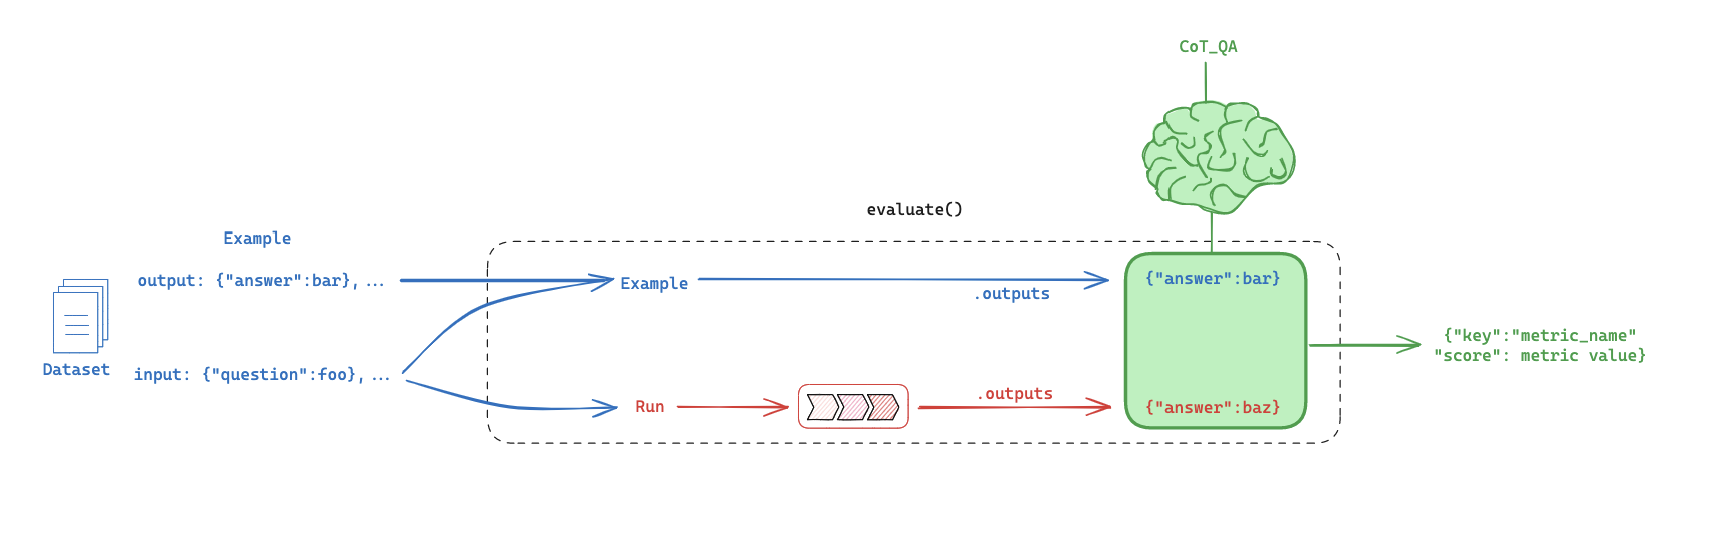

In [ ]:
# Evaluators
qa_evalulator = [LangChainStringEvaluator("cot_qa")]
dataset_name = "RAG_test_LCEL"

def predict(example: dict):
    return {"answer": rag_chain.invoke(example["question"])}
    
experiment_results = evaluate(
    predict,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="rag-qa-oai",
    # Any experiment metadata can be specified here
    metadata={
      "variant": "LCEL context, gpt-3.5-turbo",
    },
)

# 10. Online unit tests 

Nice blog post on some best practices:

https://hamel.dev/blog/posts/evals/

`Unit Tests`

* Online: Automatic retries during model inference
* Offline: CI, etc 

`Evaluation`

* Human-as-judge: Trace inspection, tagging
* LLM-as-judge: Human feedback to align grader

`A/B testing`

`Evaluating RAG`

`Fine-tuning`

* Best for learning syntax, style, and rules.
* RAG supply the model with context or up-to-date facts.

--- 

Let's focus on `Online: Automatic retries during model inference`

```
Unlike typical unit tests, you want to organize these assertions for use in places beyond unit tests, such as data cleaning and automatic retries (using the assertion error to course-correct) during model inference.
```

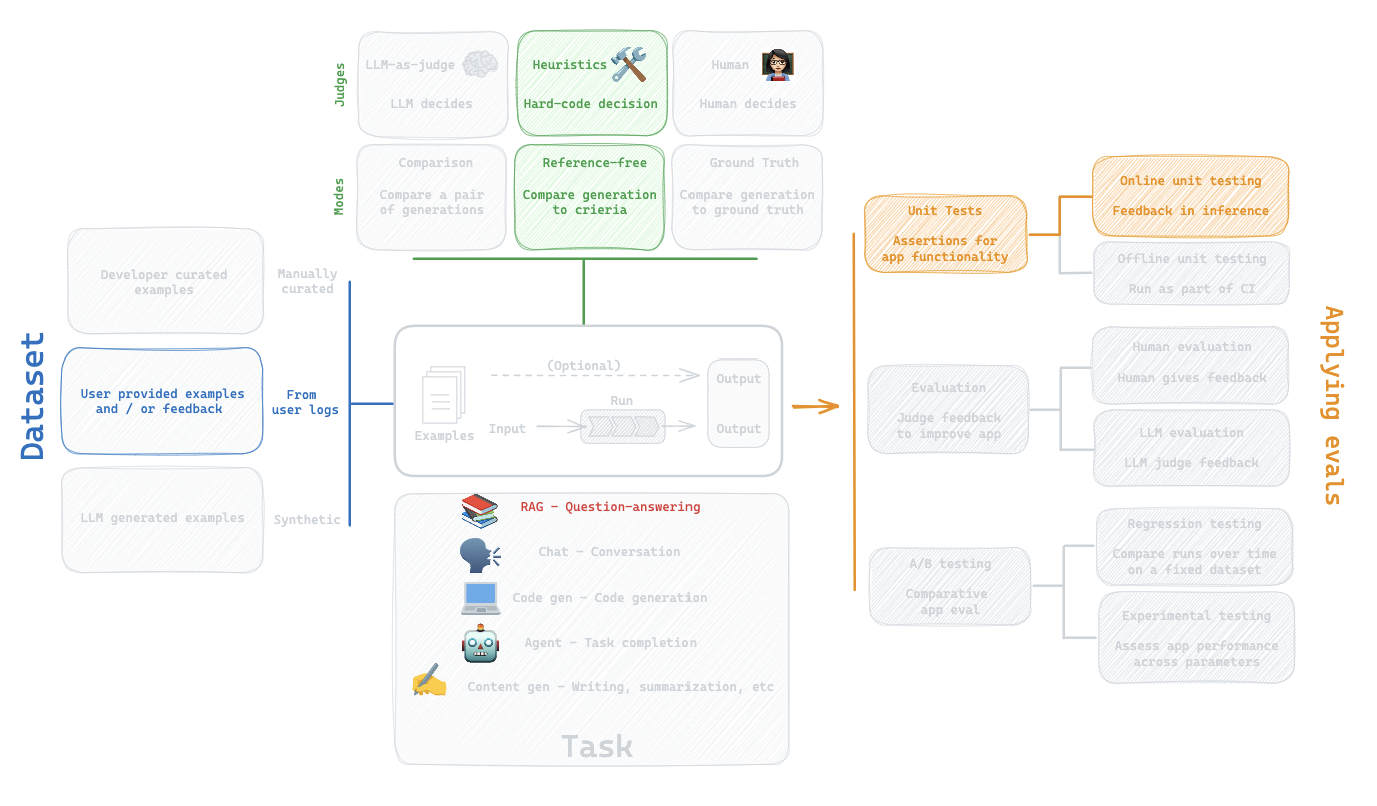

`Motivating example`:

Structured output (e.g., valid JSON) is required in many applications.

https://github.com/langchain-ai/langgraph/tree/main/examples/rag

In [ ]:
! pip install -U langchain langchain-groq

`Question:` 

How can I do online unit tests to confirm that I am outputting valid JSON?

In [15]:
import os
os.environ['LANGCHAIN_PROJECT'] = 'Groq_structured_output'

import json
from langchain_groq import ChatGroq
from langsmith.run_helpers import traceable
from langchain_core.prompts import ChatPromptTemplate

# Grader prompt 
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    """,  # Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
        ),
        ("placeholder", "{messages}"),
    ]
)

# LLM
model = ChatGroq(model="mixtral-8x7b-32768")

def parse(ai_message):
    response_str = ai_message.content
    try:
        # Parse the JSON string
        data = json.loads(response_str)

        # Check if "score" key exists
        if "score" not in data:
            raise ValueError(
                "JSON does not contain the key 'score'. JSON should contain a single key 'score' with a value of 'yes' or 'no'."
            )

    except json.JSONDecodeError:
        # Raise an error if the string is not valid JSON
        raise ValueError(
            "Invalid JSON. Please provide a valid JSON string with no preamble or explanation. YOUR ANSWER SHOULD INCLUDE NO TEXT OTHER THAN THE JSON STRING."
        )

    return data

# Chain 
chain = prompt | model | parse

In [16]:
def insert_errors(inputs):
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "user",
            f"Retry. You are required to fix the validation errors: {error}\n\nYour output MUST pass all assertions.",
        )
    ]
    return {
        "messages": messages,
        "document": inputs["document"],
        "question": inputs["question"],
    }

# This will be run as a fallback chain
fallback_chain = insert_errors | chain

# Max re-tries
N = 3
chain = chain.with_fallbacks(fallbacks=[fallback_chain] * N, exception_key="error")

In [17]:
# Sample context 
document = """
The American Civil War, spanning from 1861 to 1865, was a pivotal conflict in United States history,
rooted in deep-seated differences between the Northern and Southern states. The primary contention was over slavery 
and states' rights, with the Northern states, or the Union, advocating for the abolition of slavery, while the Southern
states, forming the Confederacy, sought to preserve and expand it. Tensions escalated following the election of Abraham 
Lincoln in 1860, leading to the secession of eleven Southern states. The war officially began with the Confederate attack 
on Fort Sumter in April 1861. Over the next four years, the conflict saw some of the bloodiest battles in American history, 
such as Gettysburg and Antietam, and was marked by strategic military campaigns, economic hardship, and vast human loss, 
with over 600,000 soldiers killed. The war ended in April 1865 with the surrender of Confederate General Robert E. Lee to 
Union General Ulysses S. Grant at Appomattox Court House, leading to the abolition of slavery and setting the stage for
the Reconstruction era that sought to rebuild and reunite the nation.
"""

# Test with an unrelated question
@traceable(run_type="chain",
           name="JSON_checker",
           tags=["doc_score"],
           metadata={"scoring": "relevant"})
def check_doc(document):
    result = chain.invoke(
        {"document": document, "question": "What is a cube root?", "messages": []}
    )
    print(result)

check_doc(document)

{'score': 'no'}
